# Building single-cell and network models in Jaxley

In this first section of the tutorial, you will learn the basics of Jaxley and how to build single-cell and network models. We will cover:
- How to construct biophysical models with the `Jaxley` simulator  
- How to connect neurons to form a network  

Some typical imports for using `Jaxley` are as follows. We will use these functions for the first section of our tutorial.

In [1]:
!pip install jaxley

/bin/bash: /home/kyra/miniconda3/envs/retina/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [2]:
import io
swc_content = """
1 1   0   0 0 10.0 -1
2 3  10   0 0 0.2 1
3 3 500   0 0 0.2 2
4 3 600 100 0 0.2 3
5 3 700 200 0 0.2 4
6 3 600 -100 0 0.2 3
7 3 700 -200 0 0.2 6
"""
swc_file = io.StringIO(swc_content)

In [3]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import matplotlib.pyplot as plt
import numpy as np

import jaxley as jx

## Building single-cell models

In [4]:
cell = jx.read_swc(swc_file, ncomp=1)

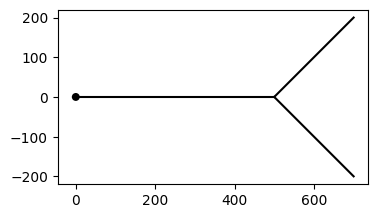

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
cell.vis(ax=ax)
ax.set_aspect("equal")

Every module tracks information about its current state and parameters in two `pandas` Dataframes called `nodes` and `edges`.
`nodes` contains all the information that we associate with compartments in the model (each row corresponds to one compartment) and `edges` tracks all the information relevant to synapses.

This means that you can easily keep track of the current state of your `Module` and how it changes at all times.

In [6]:
cell.nodes

,local_cell_index,local_branch_index,local_comp_index,length,radius,axial_resistivity,capacitance,v,x,y,z,global_cell_index,global_branch_index,global_comp_index,controlled_by_param,basal,soma
0,0,0,0,20.000000,10.0,5000.0,1.0,-70.0,0.0,0.0,0.0,0,0,0,0,False,True
1,0,1,0,490.000000,0.2,5000.0,1.0,-70.0,255.0,0.0,0.0,0,1,1,0,True,False
2,0,2,0,282.842712,0.2,5000.0,1.0,-70.0,600.0,100.0,0.0,0,2,2,0,True,False
3,0,3,0,282.842712,0.2,5000.0,1.0,-70.0,600.0,-100.0,0.0,0,3,3,0,True,False


The units of each of these values can be found [here](https://jaxley.readthedocs.io/en/latest/faq/question_01.html).

### Views

Since Modules (such as a `Cell`) can become very complex, Jaxley utilizes so called `View`s to make working with them easy and intuitive.

The simplest way to navigate Modules is as follows:

In [7]:
cell.branch(0)

View with 0 different channels. Use `.nodes` for details.

Views behave very similarly to `Module`s, i.e. `cell.branch(0)` (the 0th branch of the cell) behaves like the `cell` we instantiated earlier. As such, `cell.branch(0)` also has a `nodes` attribute, which keeps track of its part of the cell:

In [8]:
cell.branch(0).nodes

,local_cell_index,local_branch_index,local_comp_index,length,radius,axial_resistivity,capacitance,v,x,y,z,basal,soma,global_cell_index,global_branch_index,global_comp_index,controlled_by_param
0,0,0,0,20.0,10.0,5000.0,1.0,-70.0,0.0,0.0,0.0,False,True,0,0,0,0


Similarly, you can also access the soma or basal dendrite:

In [9]:
cell.soma

View with 0 different channels. Use `.nodes` for details.

In [10]:
cell.basal

View with 0 different channels. Use `.nodes` for details.

You can use `View` to visualize only parts of the cell, or different parts in different colors:

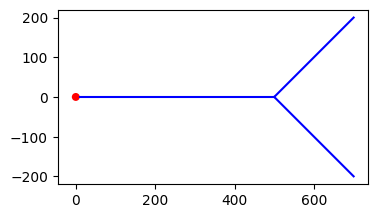

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
cell.soma.vis(ax=ax, color="r")
cell.basal.vis(ax=ax, color="b")
ax.set_aspect("equal")

More information on creating views can be found in [this tutorial](https://jaxley.readthedocs.io/en/latest/tutorials/00_jaxley_api.html) on the `Jaxley` documentation website.

### Channels

The `Cell`s that we have created above will not do anything interesting, since by default `Jaxley` initializes them without any mechanisms in the membrane. To change this, we have to insert channels into the membrane. For this purpose `Jaxley` implements `Channel`s that can be inserted into any compartment using the `insert` method of a `Module` or a `View`:

In [12]:
from jaxley.channels import Na, K, Leak

cell.insert(Leak())  # This inserts a `Leak` channel into all compartments of the cell.

This is also were `View`s come in handy, as it allows to easily target the insertion of channels to specific compartments:

In [13]:
cell.branch(0).insert(Na())
cell.branch(0).insert(K())

# K and Na channels were only insert into cell 0
cell.nodes[["global_cell_index", "Na", "K", "Leak"]]

,global_cell_index,Na,K,Leak
0,0,True,True,True
1,0,False,False,True
2,0,False,False,True
3,0,False,False,True


You can also implement your own channels. This is explained [here](https://jaxley.readthedocs.io/en/latest/tutorials/05_channel_and_synapse_models.html). In addition, the DendroTweaks toolkit implements functionality to convert `NMODL` channels (which are used by the NEURON simulator) to `Jaxley` channels. The tool is available [here](https://dendrotweaks.readthedocs.io/en/latest/tutorials/convert_to_jaxley.html).

### Changing parameters

You can change parameters of your `Cell` with the `.set()` method:

In [14]:
cell.set("axial_resistivity", 100.0)
cell.set("Na_gNa", 0.08)

> Feel free to inspect `cell.nodes` to check whether the `.set()` was successful.

> Feel free to modify other parameters. Have a look at `cell.nodes` for all things that can be changed. For example, you can modify the `capacitance`.

### Stimulating, recording, and simulating the cell

We will now set up a simulation of the network.

In [15]:
# Stimulus.
i_delay = 3.0  # ms
i_amp = 1.0  # nA
i_dur = 2.0  # ms

# Duration and step size.
dt = 0.025  # ms
t_max = 50.0  # ms

time_vec = np.arange(0.0, t_max + dt, dt)

We stimulate the neuron in a branch of its basal dendrite and record the voltage from the soma:

In [16]:
current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)

cell.delete_stimuli()
cell.basal.branch(0).loc(0.0).stimulate(current)

cell.delete_recordings()
cell.soma.branch(0).loc(0.0).record()

Added 1 external_states. See `.externals` for details.
Added 1 recordings. See `.recordings` for details.


Finally, we can run the simulation and plot the result:

In [17]:
voltages = jx.integrate(cell, delta_t=dt)

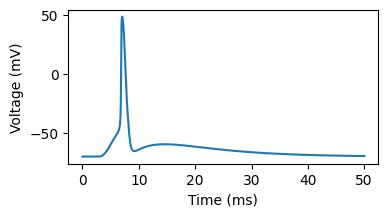

In [18]:
time_vector = np.arange(0, t_max + 2 * dt, dt)

fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = ax.plot(time_vector, voltages.T)
_ = ax.set_xlabel("Time (ms)")
_ = ax.set_ylabel("Voltage (mV)")

### Tasks for participants

1) Modify the sodium conductance (see above: `cell.set("Na_gNa", 0.08)`) and see how it impacts the simulation result.  
2) Increase the stimulus amplitude (see above: `i_amp = 1.0`) and see how it impacts the simulation result.  
3) Insert a recording into a branch of the basal dendrite and plot the voltage there.  

## Networks

Several `Cell`s can be grouped together to form a `Network`, which can then be connected together using `Synpase`s.

To get started, let us re-define the cell from scratch:

In [19]:
swc_file = io.StringIO(swc_content)
cell = jx.read_swc(swc_file, ncomp=1)

We can assemble multiple cells into a network by using `jx.Network`, which takes a list of `jx.Cell`s. Here, we assemble 11 cells into a network:

In [20]:
num_cells = 11
net = jx.Network([cell for _ in range(num_cells)])

At this point, we can already visualize this network:

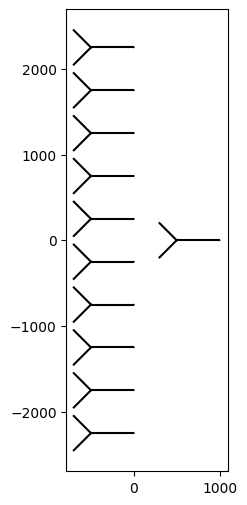

In [21]:
net.rotate(180)
net.arrange_in_layers(layers=[10, 1], within_layer_offset=500, between_layer_offset=1000)

fig, ax = plt.subplots(1, 1, figsize=(3, 6))
_ = net.vis(ax=ax, detail="full")
_ = ax.set_aspect("equal")

...but we can also visualize subsets of the network with `View`s:

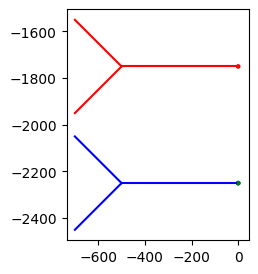

In [22]:
# ... and Views
fig, ax = plt.subplots(1,1, figsize=(3,3))
net.cell(0).vis(ax=ax, color="blue")  # View of the 0th cell of the network
net.cell(1).vis(ax=ax, color="red")  # View of the 1st cell of the network

net.cell(0).branch(0).vis(ax=ax, color="green")  # View of the 1st branch of the 0th cell of the network
ax.set_aspect("equal")

As you can see, the neurons are not connected yet. Let's fix this by connecting neurons with synapses. We will build a network consisting of two layers: 10 neurons in the input layer and 1 neuron in the output layer.

For example, we can use `Jaxley`'s `fully_connect` method to connect these layers:

In [23]:
from jaxley.connect import connect, fully_connect
from jaxley.synapses import IonotropicSynapse

pre = net.cell(range(10))
post = net.cell(10)
fully_connect(pre, post, IonotropicSynapse())

Let's visualize this again:

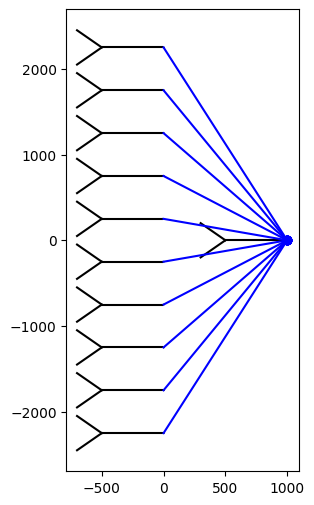

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(3, 6))
_ = net.vis(ax=ax, detail="full")

As you can see, the `fully_connect` method inserted one synapse (in blue) from every neuron in the first layer to the output neuron. The `fully_connect` method builds this synapse from the zero-eth compartment and zero-eth branch of the presynaptic neuron onto the zero-eth compartment and zero-eth branch of the postsynaptic neuron by default. Allowing the post-synaptic compartment to be randomly chosen is also possible by setting `random_post_comp=True` in the `fully_connect` call. If you want more control over the pre- and post-synaptic branches, you can use the `connect` method:

In [25]:
pre = net.cell(0).branch(2).loc(1.0)
post = net.cell(10).branch(1).loc(0.0)
connect(pre, post, IonotropicSynapse())

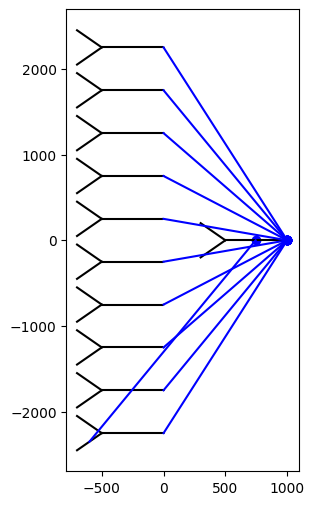

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(3, 6))
_ = net.vis(ax=ax, detail="full")

### Inspecting and changing synaptic parameters

You can inspect synaptic parameters via the `.edges` attribute:

In [27]:
net.edges

,global_edge_index,index_within_type,pre_index,post_index,type,type_ind,pre_locs,post_locs,IonotropicSynapse_gS,IonotropicSynapse_e_syn,IonotropicSynapse_k_minus,IonotropicSynapse_v_th,IonotropicSynapse_delta,IonotropicSynapse_s,controlled_by_param
0,0,0,0,60,IonotropicSynapse,0,0.5,0.5,0.0001,0.0,0.025,-35.0,10.0,0.2,0
1,1,1,6,60,IonotropicSynapse,0,0.5,0.5,0.0001,0.0,0.025,-35.0,10.0,0.2,0
2,2,2,12,60,IonotropicSynapse,0,0.5,0.5,0.0001,0.0,0.025,-35.0,10.0,0.2,0
3,3,3,18,60,IonotropicSynapse,0,0.5,0.5,0.0001,0.0,0.025,-35.0,10.0,0.2,0
4,4,4,24,60,IonotropicSynapse,0,0.5,0.5,0.0001,0.0,0.025,-35.0,10.0,0.2,0
5,5,5,30,60,IonotropicSynapse,0,0.5,0.5,0.0001,0.0,0.025,-35.0,10.0,0.2,0
6,6,6,36,60,IonotropicSynapse,0,0.5,0.5,0.0001,0.0,0.025,-35.0,10.0,0.2,0
7,7,7,42,60,IonotropicSynapse,0,0.5,0.5,0.0001,0.0,0.025,-35.0,10.0,0.2,0
8,8,8,48,60,IonotropicSynapse,0,0.5,0.5,0.0001,0.0,0.025,-35.0,10.0,0.2,0
9,9,9,54,60,IonotropicSynapse,0,0.5,0.5,0.0001,0.0,0.025,-35.0,10.0,0.2,0


To modify a parameter of all synapses you can again use `.set()`:

In [28]:
net.set("IonotropicSynapse_gS", 0.0003)  # nS

To modify individual syanptic parameters, use the `.select()` method. Below, we change the values of the first two synapses:

In [29]:
net.select(edges=[0, 1]).set("IonotropicSynapse_gS", 0.0004)  # nS

> Feel free to check out `net.edges` to make sure that the `.set()` worked.

For more details on how to flexibly set synaptic parameters (e.g., by cell type, or by pre-synaptic cell index,...), see [this tutorial](https://jaxley.readthedocs.io/en/latest/tutorials/09_advanced_indexing.html).

As a simple example, we insert sodium, potassium, and leak into every compartment of every cell of the network.

In [30]:
net.insert(Na())
net.insert(K())
net.insert(Leak())

We then stimulate every neuron in the input layer and record the voltage of the output neuron:

In [31]:
# Stimulus.
i_delay = 3.0  # ms
i_amp = 1.0  # nA
i_dur = 2.0  # ms

# Duration and step size.
dt = 0.025  # ms
t_max = 50.0  # ms

time_vec = np.arange(0.0, t_max + dt, dt)

current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
net.delete_stimuli()
for stim_ind in range(10):
    net.cell(stim_ind).branch(0).loc(0.0).stimulate(current)

net.delete_recordings()
net.cell(10).branch(0).loc(0.0).record()

Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 recordings. See `.recordings` for details.


Finally, we can again run the network simulation and plot the result:

In [32]:
voltages = jx.integrate(net, delta_t=dt)

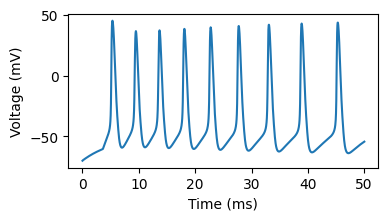

In [33]:
time_vector = np.arange(0, t_max + 2 * dt, dt)

fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = ax.plot(time_vector, voltages.T)
_ = ax.set_xlabel("Time (ms)")
_ = ax.set_ylabel("Voltage (mV)")

That's it! You now know how to simulate single cells or networks of morphologically detailed neurons. If you want, you can check out our tutorial on how you can [speed up your simulation](https://jaxley.readthedocs.io/en/latest/tutorials/04_jit_and_vmap.html). This will also explain how you can use `Jaxley` to efficiently parallelize across input stimuli or parameter sets.

### Tasks for participants

1) Modify the synaptic conductance and inspect how it impacts the output voltage.  
2) Currently, we insert sodium, potassium, and leak channels into all cells of the network. Instead, insert only the `Leak` channel everywhere, and insert sodium and potassium only in some cells, or even only in some branches of some cells. Inspect the resulting voltage.  

# Coffee break ☕

# Optimizing biophysical models

In this section of the tutorial, you will learn how to train biophysical models in `Jaxley`. This includes the following:

- compute the gradient with respect to parameters  
- use parameter transformations  
- define optimizers  
- write dataloaders and parallelize across data  

Let's get started!

In [34]:
import io
swc_content = """
1 1   0   0 0 10.0 -1
2 3  10   0 0 0.2 1
3 3 500   0 0 0.2 2
4 3 600 100 0 0.2 3
5 3 700 200 0 0.2 4
6 3 600 -100 0 0.2 3
7 3 700 -200 0 0.2 6
"""
swc_file = io.StringIO(swc_content)

In [35]:
!pip install optax

/bin/bash: /home/kyra/miniconda3/envs/retina/lib/libtinfo.so.6: no version information available (required by /bin/bash)


/home/kyra/miniconda3/envs/retina/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [36]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit, vmap, value_and_grad

import jaxley as jx
from jaxley.channels import Leak
from jaxley.synapses import TanhRateSynapse
from jaxley.connect import fully_connect

We will first define a network similar to how we showed previously:

In [37]:
_ = np.random.seed(0)  # For synaptic locations.

cell = jx.read_swc(swc_file, ncomp=1)
cell.set("axial_resistivity", 100.0)  # ohm cm.
net = jx.Network([cell for _ in range(4)])

pre = net.cell([0, 1])
post = net.cell([2, 3])
fully_connect(pre, post, TanhRateSynapse())

# Change some default values of the tanh synapse.
net.TanhRateSynapse.set("TanhRateSynapse_x_offset", -60.0)
net.TanhRateSynapse.set("TanhRateSynapse_gS", 5e-3)
net.TanhRateSynapse.set("TanhRateSynapse_slope", 0.1)

net.insert(Leak())

# Randomly initialize the synaptic weights.
_ = np.random.seed(0)
net.set("TanhRateSynapse_gS", np.random.rand(4) * 0.01)

dt = 0.025  # ms
t_max = 5.0  # ms

This network consists of four neurons arranged in two layers:

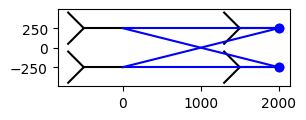

In [38]:
net.rotate(180)
net.arrange_in_layers(layers=[2, 2], within_layer_offset=500, between_layer_offset=2000)
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
_ = net.vis(ax=ax, detail="full")
_ = ax.set_aspect("equal")

We consider the voltage of the two outputs neurons as the output of the network:

In [39]:
net.delete_recordings()
net.cell(2).branch(0).loc(0.0).record()
net.cell(3).branch(0).loc(0.0).record()

Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


### Defining a dataset

We will train this biophysical network on a classification task. The inputs will be values and the label is binary:

In [40]:
inputs = jnp.asarray(0.5 * np.random.rand(100, 2))
labels = jnp.asarray((inputs[:, 0] + inputs[:, 1]) > 0.5)

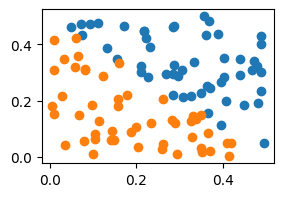

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
_ = ax.scatter(inputs[labels, 0], inputs[labels, 1])
_ = ax.scatter(inputs[~labels, 0], inputs[~labels, 1])

In [42]:
labels = labels.astype(int)

Our goal is to train the network such that the output voltages indicate class membership. In particular, we will use a cross-entropy loss, which means that the class membership will be indicated by which output neuron has a higher voltage.

### Defining trainable parameters

To train such a network, we first have to indicate which values should be optimized. For this, we use the `.make_trainable()` method.

If you want to use a single parameter for every `axial_resistivity` in the entire network, do:

In [43]:
net.delete_trainables()
net.make_trainable("axial_resistivity")

Number of newly added trainable parameters: 1. Total number of trainable parameters: 1


We can also define parameters for individual compartments. To do this, use the `"all"` key. The following defines a separate parameter the leak conductance for every compartment in the entire network:

In [44]:
net.cell("all").branch("all").loc("all").make_trainable("Leak_gLeak")

Number of newly added trainable parameters: 16. Total number of trainable parameters: 17


Synaptic parameters can be made trainable in the exact same way. To use a single parameter for all syanptic conductances in the entire network, do
```python
net.TanhRateSynapse.make_trainable("TanhRateSynapse_gS")
```

Here, we use a different syanptic conductance for all syanpses. This can be done as follows:

In [45]:
net.TanhRateSynapse.edge("all").make_trainable("TanhRateSynapse_gS")

Number of newly added trainable parameters: 4. Total number of trainable parameters: 21


Once all parameters are defined, you have to use `.get_parameters()` to obtain all trainable parameters.

In [46]:
params = net.get_parameters()

> Feel free to inspect the `params`. It contains one value for every trainable parameter.

### Stimulating the network

The network above does not yet get any stimuli. We will use the 2D inputs from the dataset to stimulate the two input neurons. The amplitude of a step current corresponds to the input value. Below is the simulator that defines this:

In [47]:
def simulate(params, inputs):
    currents = jx.datapoint_to_step_currents(i_delay=1.0, i_dur=1.0, i_amp=inputs, delta_t=dt, t_max=t_max)

    data_stimuli = None
    data_stimuli = net.cell(0).branch(0).loc(1.0).data_stimulate(currents[0], data_stimuli=data_stimuli)
    data_stimuli = net.cell(1).branch(0).loc(1.0).data_stimulate(currents[1], data_stimuli=data_stimuli)

    return jx.integrate(net, params=params, data_stimuli=data_stimuli, delta_t=dt, t_max=t_max)

batched_simulate = vmap(simulate, in_axes=(None, 0))

Let us simulate this network and plot the voltage of the output neurons:

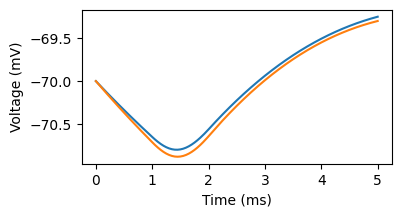

In [48]:
voltages = simulate(params, inputs[0])

time_vector = np.arange(0, t_max + dt, dt)

fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = ax.plot(time_vector, voltages.T)
_ = ax.set_xlabel("Time (ms)")
_ = ax.set_ylabel("Voltage (mV)")

### Defining a loss function

Let us define a loss function to be optimized. To this end, we first run a few initial simulation to estimate the mean and standard deviations of the output voltage. These will be used such that the cross-entropy loss function is computed on outputs that are (roughly) standardized.

In [49]:
traces = batched_simulate(params, inputs[:16])

final_states = traces[:, :, -1]  # -1 because we consider the output to be the voltage at the last time point.
final_mean = jnp.mean(final_states)
final_std = jnp.std(final_states)

Equipped with the mean and standard deviation, we will define the output of this network: The voltage at the last time point, standardized:

In [50]:
def predict(params, inputs):
    traces = simulate(params, inputs)  # Shape `(batchsize, num_recordings, timepoints)`.
    prediction = traces[:, -1]  # Use the last time point over time as prediction.
    logits = (prediction - final_mean) / final_std  # Such that the prediction is around 0.
    return logits

batched_predict = vmap(predict, in_axes=(None, 0))

...and then we define the cross-entropy loss based on the standardized inputs:

In [51]:
import optax

def loss(opt_params, inputs, labels):
    logits = batched_predict(params, inputs)
    losses = optax.softmax_cross_entropy_with_integer_labels(logits, labels)
    return jnp.mean(losses)  # Mean across elements in the batch.

jitted_grad = jit(value_and_grad(loss, argnums=0))

We can use `JAX`'s inbuilt functions to take the gradient through the entire ODE:

In [52]:
jitted_grad = jit(value_and_grad(loss, argnums=0))
prediction, gradient = jitted_grad(params, inputs[:4], labels[:4])

> Feel free to inspect the `gradient`. It contains one value for every trainable parameter and has the exact same structure as `params`.

### Defining parameter transformations

Before training, however, we will enforce for all parameters to be within a prespecified range (such that, e.g., conductances can not become negative). For this, `Jaxley` provides parameter transformations:

In [53]:
import jaxley.optimize.transforms as jt

transform = jx.ParamTransform([
    {"axial_resistivity" : jt.SigmoidTransform(50.0, 200.0)},
    {"Leak_gLeak" : jt.SigmoidTransform(5e-5, 2e-4)},
    {"TanhRateSynapse_gS" : jt.SigmoidTransform(-5e-2, 5e-2)},
])

Let's standardize the parameters:

In [54]:
opt_params = transform.inverse(params)

We now also have to modify the loss function: Before passing parameters to the simulation (which is done by `batched_predict`), we de-standardize them by running `params = transform.forward(opt_params)`.

In [55]:
def loss(opt_params, inputs, labels):
    params = transform.forward(opt_params)
    logits = batched_predict(params, inputs)
    losses = optax.softmax_cross_entropy_with_integer_labels(logits, labels)
    return jnp.mean(losses)

jitted_grad = jit(value_and_grad(loss, argnums=0))

### Training

We will use the ADAM optimizer from the [optax library](https://optax.readthedocs.io/en/latest/) to optimize the free parameters:

In [56]:
optimizer = optax.adam(learning_rate=0.001)
opt_state = optimizer.init(opt_params)

### Writing a dataloader

Below, we define a very simple dataloader. You could also rely on PyTorch or Tensorflow for the dataloader.

In [57]:
class Dataset:
    def __init__(self, inputs: np.ndarray, labels: np.ndarray):
        """Simple Dataloader.

        Args:
            inputs: Array of shape (num_samples, num_dim)
            labels: Array of shape (num_samples,)
        """
        assert len(inputs) == len(labels), "Inputs and labels must have same length"
        self.inputs = inputs
        self.labels = labels
        self.num_samples = len(inputs)
        self._rng_state = None
        self.batch_size = 1

    def shuffle(self, seed=None):
        """Shuffle the dataset in-place"""
        self._rng_state = np.random.get_state()[1][0] if seed is None else seed
        np.random.seed(self._rng_state)
        indices = np.random.permutation(self.num_samples)
        self.inputs = self.inputs[indices]
        self.labels = self.labels[indices]
        return self

    def batch(self, batch_size):
        """Create batches of the data"""
        self.batch_size = batch_size
        return self

    def __iter__(self):
        self.shuffle(seed=self._rng_state)
        for start in range(0, self.num_samples, self.batch_size):
            end = min(start + self.batch_size, self.num_samples)
            yield self.inputs[start:end], self.labels[start:end]
        self._rng_state += 1

### Training loop

That's it! We can now turn to training this network:

In [58]:
batch_size = 4
dataloader = Dataset(inputs, labels)
dataloader = dataloader.shuffle(seed=0).batch(batch_size)

for epoch in range(100):
    epoch_loss = 0.0

    for batch_ind, batch in enumerate(dataloader):
        current_batch, label_batch = batch
        loss_val, gradient = jitted_grad(opt_params, current_batch, label_batch)
        updates, opt_state = optimizer.update(gradient, opt_state)
        opt_params = optax.apply_updates(opt_params, updates)
        epoch_loss += loss_val

    if epoch % 10 == 0:
        print(f"epoch {epoch}, loss {epoch_loss}")

final_params = transform.forward(opt_params)

epoch 0, loss 16.35933577261043
epoch 10, loss 8.998765047424712
epoch 20, loss 7.041685715735813
epoch 30, loss 6.163788613585937
epoch 40, loss 5.622209739911741
epoch 50, loss 5.233389561494601
epoch 60, loss 4.913932024339249
epoch 70, loss 4.662797319497878
epoch 80, loss 4.452160869230986
epoch 90, loss 4.2705397523556945


### Evaluation

Once the training has finished, we can evaluate the trained network. To this end, we will evaluate the network on 64 inputs and check if they are being classified correctly.

In [59]:
ntest = 64
logits = batched_predict(final_params, inputs[:ntest])

In [60]:
log_probs = -optax.softmax_cross_entropy_with_integer_labels(logits, labels[:ntest])
accuracy = jnp.mean(jnp.exp(log_probs) > 0.5)
print(f"Accuracy on a subset of data: {accuracy}")

Accuracy on a subset of data: 0.9375


In [61]:
predictions = logits[:, 0] > logits[:, 1]

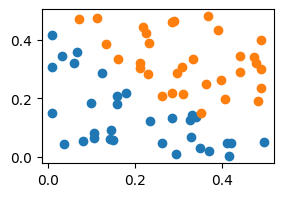

In [62]:
test_labels = predictions[:ntest].astype(bool)
test_inputs = inputs[:ntest]
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
_ = ax.scatter(test_inputs[test_labels, 0], test_inputs[test_labels, 1])
_ = ax.scatter(test_inputs[~test_labels, 0], test_inputs[~test_labels, 1])

Indeed, the network successfully classifies the patterns! Congrats!

### Tasks for participants

1) Add another trainable parameter: the reversal potential of the leak channel `Leak_eLeak`. The parameter should be shared across the entire network. Remember to also add it to the parameter transform (bounds [-90, -50]).  
2) Increase the number of epochs that the network is trained for. Observe how the final accuracy changes when training for more epochs.  

# Summary

In this tutorial, we introduced Jaxley and how to build biophysical models. More (and very similar) information can be found in our tutorials online:
- [API basics](https://github.com/jaxleyverse/jaxley/blob/main/docs/tutorials/00_jaxley_api.ipynb)
- [Single-cells with morphology](https://github.com/jaxleyverse/jaxley/blob/main/docs/tutorials/01_morph_neurons.ipynb)
- [Small networks](https://github.com/jaxleyverse/jaxley/blob/main/docs/tutorials/02_small_network.ipynb)
- [Speeding up simulations with jit and vmap](https://github.com/jaxleyverse/jaxley/blob/main/docs/tutorials/04_jit_and_vmap.ipynb)
- [Channel and synapse models](https://github.com/jaxleyverse/jaxley/blob/main/docs/tutorials/05_channel_and_synapse_models.ipynb)
- [Grouping modules](https://github.com/jaxleyverse/jaxley/blob/main/docs/tutorials/06_groups.ipynb)

The tutorial on training biophysical models with `Jaxley` closely followed our [gradient descent tutorial](https://github.com/jaxleyverse/jaxley/blob/main/docs/tutorials/07_gradient_descent.ipynb) online.

If you want to learn more, check out our [Advanced Tutorials](https://jaxley.readthedocs.io/en/latest/advanced_tutorials.html), have a look at our [paper](https://www.biorxiv.org/content/10.1101/2024.08.21.608979v1.abstract), and/or come visit one of our posters at CNS:
- Poster session 1 P065: Jaxley: Differentiable simulation enables large-scale training of detailed biophysical models of neural dynamics
- Poster session 2 P125: Modeling the biophysics of computation in the outer plexiform layer of the mouse retina

If you have any further questions, feel free to post on our [discussion forum](https://github.com/jaxleyverse/jaxley/discussions). Happy coding!